<a href="https://colab.research.google.com/github/JuniorHZ19/ArquitecturasCNN/blob/main/CNNSIMPLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#CNN SIMPLE:
import torch.nn as nn
import torch.optim as optim

# Definir un modelo simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.maxpool=nn.MaxPool2d(kernel_size=2)

        self.flatten=nn.Flatten(start_dim=1)

        self.relu=nn.ReLU()

        self.fc1 = nn.Linear(128*5*5, 128)

        self.fc2 = nn.Linear(128, 64)

        self.fc3 = nn.Linear(64, 10)

        self.dropout=nn.Dropout(0.5)


    def forward(self, x):

        x = self.conv1(x)
        x=self.relu(x)

        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)

        x = self.maxpool(x)

        x = self.flatten(x)

        x=self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x=self.dropout(x)
        x = self.relu(x)


        x=self.fc3(x)


        return x

In [3]:
def accurity(predicciones,etiquetas_reales,multiclase=False):

  if(multiclase==False):

    predicciones_clase=predicciones.round()

  else:

    predicciones_clase=torch.argmax(predicciones,dim=1) #toma dim=1 el indice maximo de la fila

  aciertos=(predicciones_clase.squeeze()==etiquetas_reales).sum().item()

  accuraty=aciertos/len(etiquetas_reales)

  return accuraty

In [4]:
def trainModel(model,epochs,dataLoader,dataLoader_test,optimiser,funcion_loss,multiclase=True):

  for epoch in range(epochs):

    epoch_loss=0

    model.train()

    for batch_data,batch_labels in (dataLoader):

       output=model(batch_data)

       loss=funcion_loss(output,batch_labels)

       optimiser.zero_grad()

       loss.backward()

       optimiser.step()

       epoch_loss +=loss.item()

    model.eval()
    accurity_total=0
    with torch.no_grad():

      for batch_data,batch_labels in (dataLoader_test):

        output=model(batch_data)

        accurity_total+=accurity(output,batch_labels,multiclase)


    accurity_promedio=accurity_total/len(dataLoader_test) # se calcula un accirty total de todos los batchs y se divide entre el total de batches para tener un promedio

    epoch_loss/=len(dataLoader)

    print(f"Época {epoch+1}, Pérdida : {epoch_loss:.4f} , Accurity:{accurity_promedio:.4f}")


  return model,optimiser



100%|██████████| 170M/170M [00:18<00:00, 9.19MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


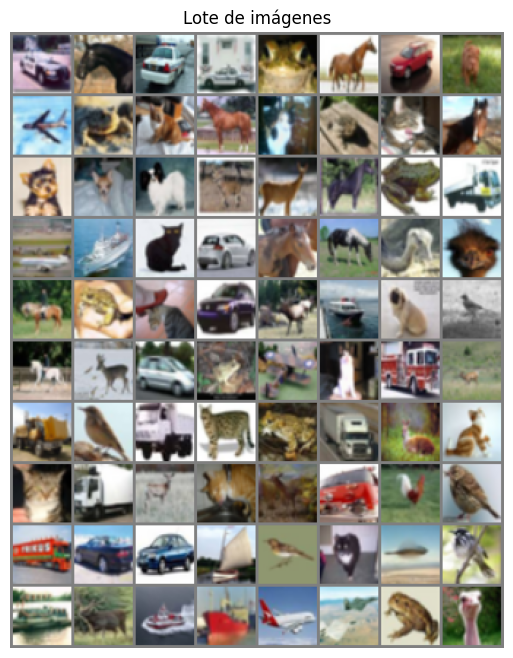

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Resize((40,40)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
])

# Cargar el dataset CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=80, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=80, shuffle=False, num_workers=2)


data_lote,labels_lote=next(iter(train_loader))

grid = make_grid(data_lote, nrow=8, padding=2)

# Convertir la cuadrícula a formato visualizable
grid_np = grid.permute(1, 2, 0).numpy()
grid_np = (grid_np * 0.5) + 0.5  # Desnormalizar si las imágenes están normalizadas

# Mostrar la cuadrícula
plt.figure(figsize=(20, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Lote de imágenes')
plt.show()

In [32]:
# Inicializar modelo, pérdida y optimizador
modelo = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=0.001, betas=(0.9,0.999))
epochs=5

modelo_entrenado,optimisador_entrenado=trainModel(modelo,epochs,train_loader,test_loader,optimizer,criterion)

Época 1, Pérdida : 1.6451 , Accurity:0.5356
Época 2, Pérdida : 1.2462 , Accurity:0.6294
Época 3, Pérdida : 1.0291 , Accurity:0.6860
Época 4, Pérdida : 0.8882 , Accurity:0.6939
Época 5, Pérdida : 0.7804 , Accurity:0.7353


Es un : bird


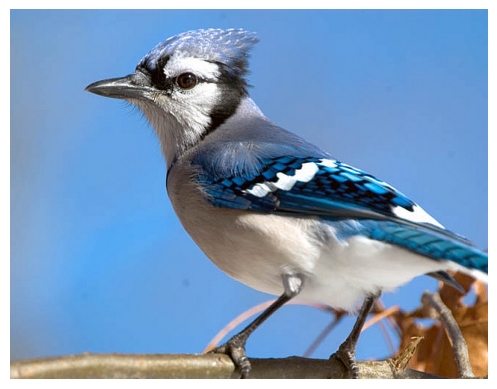

In [46]:
#Usar modelo:

from PIL import Image
import matplotlib.pyplot as plt

file_path = "/content/ave.jpeg" # @param {type:"string"}

img = Image.open(file_path)

# Transformaciones básicas para las imágenes
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Resize((40,40)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
])

tensor_img=transform(img)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

modelo_entrenado.eval()
with torch.no_grad():
 output=modelo_entrenado(tensor_img.unsqueeze(0))

max_value, max_index = torch.max(output, dim=1)

print('Es un :',classes[max_index])


plt.imshow(img)
plt.axis('off')  # Opcional: Desactiva los ejes para solo mostrar la imagen
plt.show()


In [35]:
#Guardar modelo y optimzador:

torch.save({
    'model_state_dict': modelo.state_dict(),  # Guardar solo los pesos del modelo
    'optimizer_state_dict': optimizer.state_dict()  # Guardar el estado del optimizador
}, 'checkpoint.pth')





In [ ]:
#Cargar Modelo Entrenado

modelo = SimpleCNN()  # Asegúrate de definir la clase antes
optimizer = torch.optim.Adam(modelo.parameters(), lr=0.001)  # Define el optimizador

# Cargar el checkpoint
checkpoint = torch.load('checkpoint.pth')

# Restaurar el estado del modelo y el optimizador
modelo.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Si estás en modo de predicción, coloca el modelo en modo evaluación
modelo.eval()

